<h1>Compare Real and Complex Source Separation Performance</h1>
<h2>Michael A. Casey - Bregman Labs - Dartmouth College</h2>

In [1]:
from pylab import *
from bregman.suite import *
import cseparate as cs
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
help(cs.cseparate) # COMPLEX MATRIX FACTORIZATION

Help on function cseparate in module cseparate:

cseparate(x, M=None, N=4096, H=1024, W=4096, max_iter=200)
    complex-valued frequency domain separation by independent components
    using relative phase representation
    
    inputs:
      x - the audio signal to separate (1 row)
      M - the number of sources to extract
    options:
      N - fft length in samples [4096]
      H - hop size in samples   [1024]
      W - window length in samples (fft padded with N-W zeros) [4096]
      max_iter - maximum JADE ICA iterations [200]
    output:
      xhat - the separated signals (M rows)
      xhat_all - the M separated signals mixed (1 row)
    
    Copyright (C) 2014 Michael A. Casey, Bregman Media Labs, 
    Dartmouth College All Rights Reserved



In [3]:
help(plca.PLCA.analyze) # REAL MATRIX FACTORIZATION

Help on method analyze in module bregman.plca:

analyze(cls, V, rank, niter=100, convergence_thresh=1e-09, printiter=50, plotiter=None, plotfilename=None, initW=None, initZ=None, initH=None, updateW=True, updateZ=True, updateH=True, **kwargs) method of __builtin__.type instance
    Iteratively performs the PLCA decomposition using the EM algorithm
    
    Parameters
    ----------
    V : array, shape (`F`, `T`)
        Matrix to analyze.
    niter : int
        Number of iterations to perform.  Defaults to 100.
    convergence_thresh : float
    updateW, updateZ, updateH : boolean
        If False keeps the corresponding parameter fixed.
        Defaults to True.
    initW, initZ, initH : array
        Initial settings for `W`, `Z`, and `H`.  Unused by default.
    printiter : int
        Prints current log probability once every `printiter`
        iterations.  Defaults to 50.
    plotiter : int or None
        If not None, the current decomposition is plotted once
        every `pl

In [4]:
x,sr,fmt = wavread('amen.wav')

In [5]:
def rc_err(x, reduce_mse=True):
    """
    Compare real and complex spectrum factorization and reconstruction with Mean Square Error
    inputs:
        x - the one-dimensional audio signal to factorize via its spectrum
        reduce_mse - whether to take the MSE (True) or the SE (False) for each evaluation [True]
    outputs:
        real_err - list of Real MSE (default) or SE spectra (reduce_mse=False)
        cmplx_err -list of Complex MSE (default) or SE spectra (reduce_mse=False)
    """
    x = x-x.mean() # center the original signal
    x = x/abs(x).max() # normalize the original signal
    real_err, cmplx_err = [],[] # result lists
    for K in [3,4,5,6,7]: # n_components
        for n in range(10,14): # FFT win powers of 2
            N=2**n;W=N/2;H=N/4 # FFT parameters
            # ORIGINAL SPECTRUM (normalized)
            Xo = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
            # REAL RECONSTRUCTION (normalized)
            Xr = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
            Xr.separate(cls=PLCA, n=K) # real separation (PLCA)
            # REAL ERROR            
            rX = array(Xr.X_hat)[:,:, :Xo.X.shape[1]].sum(0) # Real spectral components summed
            sqerr_real = (Xo.X - rX)**2            
            # COMPLEX RECONSTRUCTION (normalized)
            xci, xc = cs.cseparate(x,K,N,H,W) # complex separation (CJADE)
            xc = xc-xc.mean() # center
            xc = xc/abs(xc).max() # normalize
            Xc = LinearFrequencySpectrum(xc, nfft=N, wfft=W, nhop=H)
            # COMPLEX ERROR
            cX = Xc.X[:,:Xo.X.shape[1]] # Complex spectral components already summed by cseparate
            sqerr_cmplx = (Xo.X - cX)**2
            # Append Results
            cmplx_err.append(sqerr_cmplx)
            real_err.append(sqerr_real)
    if reduce_mse:
        real_err = [r.mean() for r in real_err]
        cmplx_err = [c.mean() for c in cmplx_err]            
    return real_err, cmplx_err

In [6]:
# Run the experiment
real_err,cmplx_err = rc_err(x) 

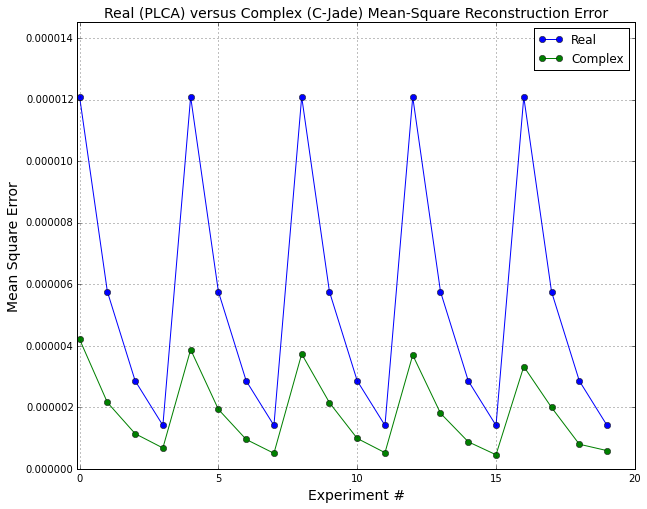

In [7]:
# Plot the results of the experiment
plot(real_err,'-o')
plot(cmplx_err,'-o')
title('Real (PLCA) versus Complex (C-Jade) Mean-Square Reconstruction Error', fontsize=14)
ylabel('Mean Square Error', fontsize=14)
xlabel('Experiment #', fontsize=14)
legend(['Real','Complex'])
axis(xmin=-0.1, ymax=max(max(real_err),max(cmplx_err))*1.2) # Autoscale y axis
grid()